# DeepBiome: Metagenomics

Aug. 30. 2020
@ Youngwon (youngwon08@gmail.com)

In [1]:
import os
import json
import numpy as np
import pandas as pd
import copy
import logging
import sys

import keras.backend as k
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES']=''

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from deepbiome.deepbiome import *

In [3]:
if not tf.__version__.startswith('2'): 
    config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
    k.set_session(tf.Session(config=config))

## Pick Models

In [4]:
save = False
kfold=5
# kfold=20
network_model_keys = ['optimizer','lr','decay']
architecture_keys = ['weight_decay', 'weight_l1_penalty', #'weight_l2_penalty',
                     'tree_thrd', 'weight_initial',
                     'batch_normalization','drop_out']
network_training_keys = ['batch_size','epochs']

logging.basicConfig(format = '[%(name)-8s|%(levelname)s|%(filename)s:%(lineno)s] %(message)s',
                    level=logging.DEBUG)
log = logging.getLogger()

In [5]:
filenames = 'simulation_metagenomics.Rmd'
models = [
          'realdata_metagenomics/t2d_deep',
          'realdata_metagenomics/t2d_deep_l1',
          'realdata_metagenomics/t2d_deepbiome',
         ]

models_aka = [
          'DNN',
          'DNN+$\ell_1$',
          'DeepBiome',
         ]
num_classes = 1

In [6]:
model_network_info = {}
model_path_info = {}
for model_path in models:
    config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
    config_data.set_config_map(config_data.get_section_map())
    config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
    config_network.set_config_map(config_network.get_section_map())

    model_path_info[model_path] = config_data.get_config_map()
    model_network_info[model_path] = config_network.get_config_map()
    
if num_classes == 0: y_names = ['loss','correlation_coefficient']
elif num_classes==1: y_names = ['loss','binary_accuracy','sensitivity','specificity','gmeasure', 'auc']
else: y_names=['loss','categorical_accuracy','precision','recall','f1', 'auc']

if num_classes == 0: measure_index = np.array([0,1])
elif num_classes==1: measure_index = np.array([2,3,4,1,5])
else: measure_index = np.array([1,2,3,4,5])

## Accuracy

In [7]:
results = []
# log.info('%20s & %s' % ('model', '& '.join(['%s ' % name for name in np.array(y_names)[[measure_index]]])))
print('%10s & %s \\\\\ \hline' % ('model', '& '.join(['%7s &   (sd) ' % name for name in np.array(y_names)[[measure_index]]])))
# for model, aka in zip(models, models_aka):
#     evaluation = np.load('%s/eval.npy' % model)
#     log.info('%20s: %s' % (aka, ''.join(['%10.4f (%10.4f)'%(mean, std) for mean, std in zip(np.mean(evaluation, axis=0),np.std(evaluation, axis=0))])))
#     results.append(np.vstack([np.mean(evaluation, axis=0),np.std(evaluation, axis=0)]).transpose())
for model, aka in zip(models, models_aka):
    train_evaluation = np.load('%s/train_eval.npy' % model)[:,measure_index]
    train_res = '&'.join(['%7.3f & %7.3f'%(mean, std) for mean, std in zip(np.nanmean(train_evaluation, axis=0),np.nanstd(train_evaluation, axis=0))])
    test_evaluation = np.load('%s/test_eval.npy' % model)[:,measure_index]
    test_res = '&'.join(['%7.3f & %7.3f'%(mean, std) for mean, std in zip(np.nanmean(test_evaluation, axis=0),np.nanstd(test_evaluation, axis=0))])
#     log.info('%s & %s & %s \\\\' % (aka, train_res, test_res))
    print('%10s & %s & %s \\\\' % (aka, test_res, train_res))
#     results.append(np.vstack([np.mean(evaluation, axis=0),np.std(evaluation, axis=0)]).transpose())

     model & sensitivity &   (sd) & specificity &   (sd) & gmeasure &   (sd) & binary_accuracy &   (sd) &     auc &   (sd)  \\\ \hline
       DNN &   0.578 &   0.389&  0.547 &   0.384&  0.391 &   0.119&  0.532 &   0.041&  0.680 &   0.037 &   0.660 &   0.341&  0.642 &   0.338&  0.542 &   0.165&  0.656 &   0.083&  0.853 &   0.027 \\
DNN+$\ell_1$ &   0.703 &   0.262&  0.497 &   0.278&  0.523 &   0.061&  0.590 &   0.040&  0.681 &   0.045 &   0.785 &   0.226&  0.618 &   0.250&  0.653 &   0.083&  0.702 &   0.053&  0.846 &   0.015 \\
 DeepBiome &   0.431 &   0.239&  0.788 &   0.147&  0.496 &   0.251&  0.607 &   0.069&  0.607 &   0.101 &   0.527 &   0.296&  0.860 &   0.103&  0.584 &   0.303&  0.695 &   0.120&  0.776 &   0.119 \\


In [8]:
for model, aka in zip(models, models_aka):
    print('---------------------------------------------------------------------------------------------------------')
    print('%14s test' % aka)
    print('---------------------------------------------------------------------------------------------------------')
    test_evaluation = np.load('%s/test_eval.npy' % model)[:,measure_index]
    print('      %s' % ''.join(['%16s'%s.strip() for s in np.array(y_names)[[measure_index]]]))
    print('Mean: %s' % ''.join(['%16.4f'%v for v in np.mean(test_evaluation, axis=0)]))
    print('Std : %s' % ''.join(['%16.4f'%v for v in np.std(test_evaluation, axis=0)]))

---------------------------------------------------------------------------------------------------------
           DNN test
---------------------------------------------------------------------------------------------------------
           sensitivity     specificity        gmeasure binary_accuracy             auc
Mean:           0.5777          0.5465          0.3914          0.5318          0.6804
Std :           0.3889          0.3842          0.1192          0.0411          0.0366
---------------------------------------------------------------------------------------------------------
  DNN+$\ell_1$ test
---------------------------------------------------------------------------------------------------------
           sensitivity     specificity        gmeasure binary_accuracy             auc
Mean:           0.7035          0.4968          0.5233          0.5900          0.6808
Std :           0.2619          0.2780          0.0606          0.0402          0.0450
--------------

# Weight estimation of DeepBiom

## DNN

In [9]:
num=0
model_path = models[num]
model_aka = models_aka[num]

config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
config_data.set_config_map(config_data.get_section_map())
config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
config_network.set_config_map(config_network.get_section_map())

path_info = config_data.get_config_map()
network_info = config_network.get_config_map()

path_info['data_info']['data_path'] = '/'.join(path_info['data_info']['data_path'].split('/')[2:])
path_info['data_info']['tree_info_path'] = '/'.join(path_info['data_info']['tree_info_path'].split('/')[2:])
try: path_info['data_info']['count_list_path'] = '/'.join(path_info['data_info']['count_list_path'].split('/')[2:])
except: pass
try: path_info['data_info']['count_path'] = '/'.join(path_info['data_info']['count_path'].split('/')[2:])
except: pass
path_info['data_info']['idx_path'] = '/'.join(path_info['data_info']['idx_path'].split('/')[2:])

path_info['model_info']['model_dir'] = './%s/%s'%(model_path,path_info['model_info']['model_dir'])

log.info('%22s : %s' % ('model', model_path))
log.info('%22s : %s' % ('model_aka', model_aka))
for k in architecture_keys:
    log.info('%22s : %s' % (k, network_info['architecture_info'].get(k, None)))
for k in network_model_keys:
    log.info('%22s : %s' % (k, network_info['model_info'].get(k, None)))
for k in network_training_keys:
    log.info('%22s : %s' % (k, network_info['training_info'].get(k, None)))

[root    |INFO|<ipython-input-9-d8282ac4ffbb>:23]                  model : realdata_metagenomics/t2d_deep
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:24]              model_aka : DNN
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:26]           weight_decay : None
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:26]      weight_l1_penalty : None
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:26]              tree_thrd : None
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:26]         weight_initial : glorot_uniform
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:26]    batch_normalization : False
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:26]               drop_out : 0
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:28]              optimizer : adam
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:28]                     lr : 0.01
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:28]                  decay : 0.001
[root    |INFO|<ipython-input-9-d8282ac4ffbb>:30]             batch_size : 60
[root   

In [10]:
weight_path = '%s/weight/%s' % (path_info['model_info']['model_dir'], 'weight_0.h5')
trained_weight_list = deepbiome_get_trained_weight(log, network_info, path_info, num_classes=1, weight_path=weight_path,
                                                  tree_level_list=['Species','Genus', 'Family', 'Order', 'Class', 'Phylum'])
log.info(len(trained_weight_list))

[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from data/metagenomics/clean_t2d/t2d_species606_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum']
[root    |INFO|build_network.py:529] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:537]     Species: 606
[root    |INFO|build_network.py:537]      Genus: 216
[root    |INFO|build_network.py:537]     Family: 94
[root    |INFO|build_network.py:537]   

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[tensorflow|WARNING|deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[root    |INFO|build_network.py:670] ------------------------------------------------------------------------------------------


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 606)               0         
_________________________________________________________________
l1_dense (Dense_with_new_tre (None, 216)               131112    
_________________________________________________________________
l1_activation (Activation)   (None, 216)               0         
_________________________________________________________________
l2_dense (Dense_with_new_tre (None, 94)                20398     
_________________________________________________________________
l2_activation (Activation)   (None, 94)                0         
_________________________________________________________________
l3_dense (Dense_with_new_tre (None, 48)                4560      
_________________________________________________________________
l3_activation (Activation)   (None, 48)                0   

[root    |INFO|<ipython-input-10-2877830b15aa>:4] 6


In [11]:
log.info(trained_weight_list[0].shape)

[root    |INFO|<ipython-input-11-e35650775530>:1] (606, 216)


In [12]:
trained_weight_list[0]

,Methanobrevibacter,Methanosphaera,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,...,Xanthomonas,Microlunatus,Meiothermus,Alicyclobacillus,Shinella,Pseudoalteromonas,Vibrio,Mycoplasma,Zunongwangia,Rhodopirellula
Methanobrevibacter_smithii,0.062,-0.022,-0.028,-0.093,-0.043,0.045,-0.033,0.018,0.078,0.035,...,0.021,-0.043,-0.041,0.092,0.063,0.035,-0.021,-0.001,0.073,0.042
Methanobrevibacter_unclassified,0.006,-0.004,-0.035,-0.094,0.085,0.053,0.042,0.035,0.034,-0.060,...,-0.025,-0.078,-0.022,0.128,-0.018,0.107,0.035,-0.069,-0.019,0.063
Methanosphaera_stadtmanae,-0.053,-0.053,0.001,0.055,-0.004,-0.018,-0.056,0.019,0.108,-0.019,...,-0.075,-0.045,-0.020,0.108,0.002,-0.026,0.102,0.107,0.048,0.041
Acidobacteriaceae_unclassified,0.025,-0.034,-0.064,-0.023,0.044,-0.082,0.074,0.051,0.002,-0.085,...,0.042,0.017,0.081,-0.000,0.042,-0.030,0.041,-0.021,0.033,-0.047
Actinomyces_graevenitzii,-0.085,-0.092,0.040,0.051,-0.038,-0.047,-0.031,0.070,-0.067,0.079,...,-0.021,0.038,-0.111,-0.031,0.021,0.036,-0.068,-0.038,-0.091,-0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rhodopirellula_unclassified,-0.027,0.074,-0.063,-0.028,-0.024,-0.069,-0.038,-0.033,-0.020,-0.027,...,0.015,-0.076,0.016,-0.073,0.039,0.020,0.044,0.064,-0.002,-0.037
Vibrio_furnissii,0.062,-0.080,0.001,0.055,-0.013,-0.031,-0.037,-0.005,-0.067,0.014,...,-0.023,0.007,-0.078,-0.007,-0.080,-0.056,0.067,0.004,0.069,-0.000
Bacteroides_sp_2_2_4,-0.063,-0.034,-0.021,-0.054,-0.011,0.018,-0.010,-0.032,0.005,-0.066,...,0.074,0.048,-0.004,0.011,-0.080,0.048,-0.061,-0.024,-0.023,-0.085
Lysinibacillus_fusiformis,-0.036,0.004,-0.036,0.035,-0.065,0.029,-0.046,-0.030,-0.003,-0.017,...,-0.014,-0.035,0.017,-0.076,0.022,0.013,0.016,0.008,0.017,0.018


## DNN + $\ell_1$

In [13]:
num=1
model_path = models[num]
model_aka = models_aka[num]

config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
config_data.set_config_map(config_data.get_section_map())
config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
config_network.set_config_map(config_network.get_section_map())

path_info = config_data.get_config_map()
network_info = config_network.get_config_map()

path_info['data_info']['data_path'] = '/'.join(path_info['data_info']['data_path'].split('/')[2:])
path_info['data_info']['tree_info_path'] = '/'.join(path_info['data_info']['tree_info_path'].split('/')[2:])
try: path_info['data_info']['count_list_path'] = '/'.join(path_info['data_info']['count_list_path'].split('/')[2:])
except: pass
try: path_info['data_info']['count_path'] = '/'.join(path_info['data_info']['count_path'].split('/')[2:])
except: pass
path_info['data_info']['idx_path'] = '/'.join(path_info['data_info']['idx_path'].split('/')[2:])

path_info['model_info']['model_dir'] = './%s/%s'%(model_path,path_info['model_info']['model_dir'])

log.info('%22s : %s' % ('model', model_path))
log.info('%22s : %s' % ('model_aka', model_aka))
for k in architecture_keys:
    log.info('%22s : %s' % (k, network_info['architecture_info'].get(k, None)))
for k in network_model_keys:
    log.info('%22s : %s' % (k, network_info['model_info'].get(k, None)))
for k in network_training_keys:
    log.info('%22s : %s' % (k, network_info['training_info'].get(k, None)))

[root    |INFO|<ipython-input-13-a38160c4c3ee>:23]                  model : realdata_metagenomics/t2d_deep_l1
[root    |INFO|<ipython-input-13-a38160c4c3ee>:24]              model_aka : DNN+$\ell_1$
[root    |INFO|<ipython-input-13-a38160c4c3ee>:26]           weight_decay : None
[root    |INFO|<ipython-input-13-a38160c4c3ee>:26]      weight_l1_penalty : 0.01
[root    |INFO|<ipython-input-13-a38160c4c3ee>:26]              tree_thrd : None
[root    |INFO|<ipython-input-13-a38160c4c3ee>:26]         weight_initial : glorot_uniform
[root    |INFO|<ipython-input-13-a38160c4c3ee>:26]    batch_normalization : False
[root    |INFO|<ipython-input-13-a38160c4c3ee>:26]               drop_out : 0
[root    |INFO|<ipython-input-13-a38160c4c3ee>:28]              optimizer : adam
[root    |INFO|<ipython-input-13-a38160c4c3ee>:28]                     lr : 0.01
[root    |INFO|<ipython-input-13-a38160c4c3ee>:28]                  decay : 0.001
[root    |INFO|<ipython-input-13-a38160c4c3ee>:30]             

In [14]:
weight_path = '%s/weight/%s' % (path_info['model_info']['model_dir'], 'weight_0.h5')
trained_weight_list = deepbiome_get_trained_weight(log, network_info, path_info, num_classes=1, weight_path=weight_path,
                                                  tree_level_list=['Species','Genus', 'Family', 'Order', 'Class', 'Phylum'])
log.info(len(trained_weight_list))

[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from data/metagenomics/clean_t2d/t2d_species606_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum']
[root    |INFO|build_network.py:529] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:537]     Species: 606
[root    |INFO|build_network.py:537]      Genus: 216
[root    |INFO|build_network.py:537]     Family: 94
[root    |INFO|build_network.py:537]   

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 606)               0         
_________________________________________________________________
l1_dense (Dense_with_new_tre (None, 216)               131112    
_________________________________________________________________
l1_activation (Activation)   (None, 216)               0         
_________________________________________________________________
l2_dense (Dense_with_new_tre (None, 94)                20398     
_________________________________________________________________
l2_activation (Activation)   (None, 94)                0         
_________________________________________________________________
l3_dense (Dense_with_new_tre (None, 48)                4560      
_________________________________________________________________
l3_activation (Activation)   (None, 48)                0   

[root    |INFO|<ipython-input-14-2877830b15aa>:4] 6


In [15]:
log.info(trained_weight_list[0].shape)

[root    |INFO|<ipython-input-15-e35650775530>:1] (606, 216)


In [16]:
trained_weight_list[0]

,Methanobrevibacter,Methanosphaera,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,...,Xanthomonas,Microlunatus,Meiothermus,Alicyclobacillus,Shinella,Pseudoalteromonas,Vibrio,Mycoplasma,Zunongwangia,Rhodopirellula
Methanobrevibacter_smithii,0.086,-0.109,-0.020,0.073,0.037,0.029,-0.040,0.112,0.099,0.042,...,-0.021,-0.053,-0.004,0.009,0.022,-0.016,0.034,0.105,0.099,0.036
Methanobrevibacter_unclassified,0.012,-0.000,-0.033,-0.021,-0.017,-0.016,-0.097,0.071,0.062,-0.048,...,0.019,-0.077,0.054,-0.014,0.076,-0.057,0.093,-0.002,-0.022,-0.004
Methanosphaera_stadtmanae,-0.049,-0.040,0.001,0.080,0.065,0.036,0.040,-0.053,-0.033,0.086,...,0.093,0.004,0.051,-0.019,-0.028,-0.037,-0.051,0.000,-0.046,0.090
Acidobacteriaceae_unclassified,0.033,-0.072,0.083,0.053,-0.065,0.043,-0.037,0.076,0.081,0.068,...,-0.026,0.040,-0.075,0.064,0.023,-0.034,-0.063,0.031,0.084,-0.050
Actinomyces_graevenitzii,-0.062,0.111,-0.059,-0.036,0.013,-0.025,-0.024,0.053,-0.080,0.070,...,-0.055,-0.061,0.095,0.065,0.059,0.080,-0.030,0.016,-0.007,0.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rhodopirellula_unclassified,0.064,0.078,-0.005,0.007,0.085,-0.076,-0.052,-0.048,-0.003,-0.005,...,0.064,-0.059,0.041,-0.020,-0.082,-0.052,-0.065,0.049,-0.046,-0.050
Vibrio_furnissii,-0.000,0.048,0.067,0.065,-0.077,-0.011,0.007,0.008,0.054,-0.059,...,-0.027,-0.056,0.020,0.065,0.054,0.003,0.048,-0.049,0.024,0.065
Bacteroides_sp_2_2_4,0.019,0.033,0.045,-0.023,-0.058,0.038,-0.045,-0.041,-0.005,-0.072,...,0.055,0.006,-0.017,-0.012,-0.066,0.012,0.001,-0.053,-0.016,0.054
Lysinibacillus_fusiformis,0.019,-0.032,0.032,-0.055,0.061,-0.067,-0.026,-0.041,0.050,-0.014,...,-0.020,-0.011,-0.072,-0.067,-0.049,-0.055,-0.051,-0.019,-0.083,-0.014


## DeepBiome

In [17]:
num=2
model_path = models[num]
model_aka = models_aka[num]

config_data = configuration.Configurator('%s/config/path_info.cfg' % model_path, log, verbose=False)
config_data.set_config_map(config_data.get_section_map())
config_network = configuration.Configurator('%s/config/network_info.cfg' % model_path, log, verbose=False)
config_network.set_config_map(config_network.get_section_map())

path_info = config_data.get_config_map()
network_info = config_network.get_config_map()

path_info['data_info']['data_path'] = '/'.join(path_info['data_info']['data_path'].split('/')[2:])
path_info['data_info']['tree_info_path'] = '/'.join(path_info['data_info']['tree_info_path'].split('/')[2:])
try: path_info['data_info']['count_list_path'] = '/'.join(path_info['data_info']['count_list_path'].split('/')[2:])
except: pass
try: path_info['data_info']['count_path'] = '/'.join(path_info['data_info']['count_path'].split('/')[2:])
except: pass
path_info['data_info']['idx_path'] = '/'.join(path_info['data_info']['idx_path'].split('/')[2:])

path_info['model_info']['model_dir'] = './%s/%s'%(model_path,path_info['model_info']['model_dir'])

log.info('%22s : %s' % ('model', model_path))
log.info('%22s : %s' % ('model_aka', model_aka))
for k in architecture_keys:
    log.info('%22s : %s' % (k, network_info['architecture_info'].get(k, None)))
for k in network_model_keys:
    log.info('%22s : %s' % (k, network_info['model_info'].get(k, None)))
for k in network_training_keys:
    log.info('%22s : %s' % (k, network_info['training_info'].get(k, None)))

[root    |INFO|<ipython-input-17-73ec9f5bae7c>:23]                  model : realdata_metagenomics/t2d_deepbiome
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:24]              model_aka : DeepBiome
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:26]           weight_decay : phylogenetic_tree
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:26]      weight_l1_penalty : None
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:26]              tree_thrd : None
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:26]         weight_initial : glorot_uniform
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:26]    batch_normalization : False
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:26]               drop_out : 0
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:28]              optimizer : adam
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:28]                     lr : 0.01
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:28]                  decay : 0.001
[root    |INFO|<ipython-input-17-73ec9f5bae7c>:30] 

In [18]:
weight_path = '%s/weight/%s' % (path_info['model_info']['model_dir'], 'weight_0.h5')
trained_weight_list = deepbiome_get_trained_weight(log, network_info, path_info, num_classes=1, weight_path=weight_path,
                                                  tree_level_list=['Species','Genus', 'Family', 'Order', 'Class', 'Phylum'])
log.info(len(trained_weight_list))

[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data
[root    |INFO|build_network.py:521] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:522] Read phylogenetic tree information from data/metagenomics/clean_t2d/t2d_species606_dic.csv
[root    |INFO|build_network.py:528] Phylogenetic tree level list: ['Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum']
[root    |INFO|build_network.py:529] ------------------------------------------------------------------------------------------
[root    |INFO|build_network.py:537]     Species: 606
[root    |INFO|build_network.py:537]      Genus: 216
[root    |INFO|build_network.py:537]     Family: 94
[root    |INFO|build_network.py:537]   

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 606)               0         
_________________________________________________________________
l1_dense (Dense_with_tree)   (None, 216)               131112    
_________________________________________________________________
l1_activation (Activation)   (None, 216)               0         
_________________________________________________________________
l2_dense (Dense_with_tree)   (None, 94)                20398     
_________________________________________________________________
l2_activation (Activation)   (None, 94)                0         
_________________________________________________________________
l3_dense (Dense_with_tree)   (None, 48)                4560      
_________________________________________________________________
l3_activation (Activation)   (None, 48)                0   

[root    |INFO|<ipython-input-18-2877830b15aa>:4] 6


In [19]:
log.info(trained_weight_list[0].shape)

[root    |INFO|<ipython-input-19-e35650775530>:1] (606, 216)


In [20]:
trained_weight_list[0]

,Methanobrevibacter,Methanosphaera,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,...,Xanthomonas,Microlunatus,Meiothermus,Alicyclobacillus,Shinella,Pseudoalteromonas,Vibrio,Mycoplasma,Zunongwangia,Rhodopirellula
Methanobrevibacter_smithii,-0.022,-0.000,0.001,-0.000,0.001,-0.001,-0.000,0.000,0.000,-0.000,...,0.000,-0.001,-0.000,0.000,-0.000,0.000,-0.000,-0.001,0.000,-0.000
Methanobrevibacter_unclassified,0.018,0.000,-0.001,0.000,-0.000,0.001,0.000,0.000,-0.001,0.000,...,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.001,-0.001
Methanosphaera_stadtmanae,0.001,0.226,0.000,0.000,-0.000,-0.001,0.000,-0.001,0.001,0.001,...,0.000,-0.001,0.001,0.000,-0.001,-0.001,-0.000,0.000,-0.001,0.000
Acidobacteriaceae_unclassified,0.000,0.000,-0.024,0.000,0.000,0.000,0.000,0.000,0.001,-0.000,...,0.000,0.000,0.000,0.001,-0.000,-0.001,-0.000,-0.001,0.000,0.000
Actinomyces_graevenitzii,-0.000,-0.000,0.001,-0.067,-0.000,0.000,-0.001,-0.000,-0.000,0.001,...,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.001,0.000,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rhodopirellula_unclassified,0.000,-0.000,0.000,0.000,-0.001,-0.001,0.001,-0.000,-0.000,0.000,...,-0.000,-0.000,-0.000,-0.000,0.001,0.001,0.000,0.000,0.000,0.025
Vibrio_furnissii,0.001,0.001,0.001,-0.000,0.000,-0.000,0.000,0.000,0.000,0.001,...,0.000,0.001,-0.001,0.000,0.000,-0.001,-0.054,-0.000,0.000,-0.001
Bacteroides_sp_2_2_4,0.000,0.001,0.001,-0.001,-0.000,0.001,0.001,-0.001,0.001,0.000,...,0.000,-0.001,0.001,0.001,-0.000,0.001,0.001,-0.001,0.001,-0.000
Lysinibacillus_fusiformis,-0.000,-0.000,-0.001,-0.000,0.000,0.001,-0.000,-0.000,0.000,-0.000,...,-0.000,0.000,-0.001,0.000,0.000,-0.001,-0.001,-0.000,0.001,0.001


In [21]:
tot_trained_weight_list = []
for fold in range(kfold):
    weight_path = '%s/weight/%s' % (path_info['model_info']['model_dir'], 'weight_%d.h5' % fold)
    trained_weight_list = deepbiome_get_trained_weight(log, network_info, path_info, num_classes=1,
                                                       weight_path=weight_path,
                                                       tree_level_list=['Species','Genus', 'Family', 'Order', 'Class', 'Phylum'],
                                                       verbose=False)
    tot_trained_weight_list.append(trained_weight_list)
    
trained_weight_list = []
for i in range(len(tot_trained_weight_list[0])):
    level_weights = tot_trained_weight_list[0][i]
    for j in range(1,len(tot_trained_weight_list)):
        level_weights +=tot_trained_weight_list[j][i]
    level_weights /= len(tot_trained_weight_list)
    trained_weight_list.append(level_weights)

In [22]:
phylum_color = ['lemonchiffon',
                 'lightsteelblue',
                 'moccasin',
                 'darkseagreen',
                 'khaki',
                 'mediumturquoise',
                 'thistle',
                 'tan',
                 'mistyrose',
                 'lavender',
                 'teal',
                 'plum',
                 'cyan',
                 'orange',
                 'lightpink',
                 'violet',
                 'hotpink',
                 'deepskyblue',
#                  'lightpink',
#                  'violet',
#                  'hotpink',
#                  'deepskyblue'
                ]
len(phylum_color)

18

In [23]:
# img = deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes=1,
#                                      file_name='%%inline', img_w=1000,
#                                      branch_vertical_margin=10, arc_start=0, arc_span=360,
#                                      node_name_on=True, name_fsize=50,
#                                      tree_weight_on=True, tree_weight=trained_weight_list,
#                                      tree_level_list=['Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum'],
#                                      weight_opacity=0.8, weight_max_radios=30,
#                                      phylum_background_color_on=True, phylum_color=phylum_color, phylum_color_legend=True,
#                                      show_covariates=False,
#                                      verbose=True)
# img

[root    |INFO|readers.py:58] -----------------------------------------------------------------------
[root    |INFO|readers.py:59] Construct Dataset
[root    |INFO|readers.py:60] -----------------------------------------------------------------------
[root    |INFO|readers.py:61] Load data


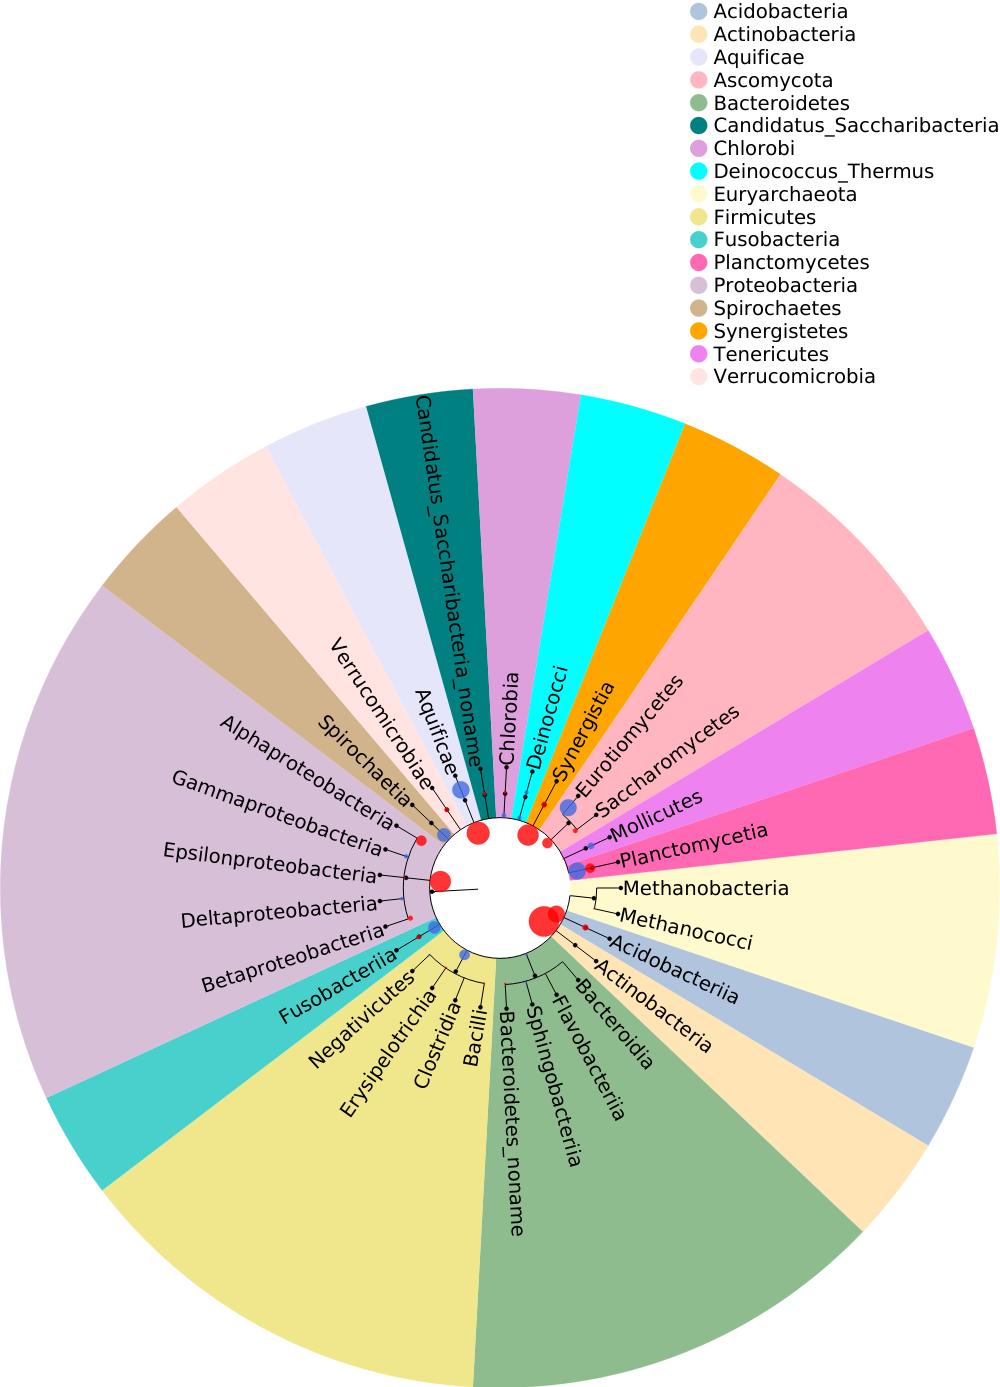

In [24]:
img = deepbiome_draw_phylogenetic_tree(log, network_info, path_info, num_classes=1,
                                     file_name='%%inline', img_w=1000,
                                     branch_vertical_margin=10, arc_start=0, arc_span=360,
                                     node_name_on=True, name_fsize=50,
                                     tree_weight_on=True, tree_weight=trained_weight_list[4:],
                                     tree_level_list = ['Class', 'Phylum', 'Disease'],
                                     weight_opacity=0.8, weight_max_radios=30,
                                     phylum_background_color_on=True, phylum_color=phylum_color, phylum_color_legend=True,
                                     show_covariates=False,
                                     verbose=True)
img